## Scientific validation of memento implementations

This notebook runs through test cases for differential expression where the p-value outputs
of vanilla memento implementation are compared to the p-value outputs of precomputed memento
implementation

**NOTE**:
- Run this notebook from the `cellxgene-census` repo in the `psridharan/memento-sci-val-1` branch
- Download estimator cube from `s3://psridharan-tmp/memento/memento-cube-census-data-2023-12-15/`

In [31]:
import matplotlib.pyplot as plt
import memento
import numpy as np

import cellxgene_census
import cellxgene_census.experimental.diffexp.memento.diff_expr as precomputed_memento

census = cellxgene_census.open_soma(census_version="2023-12-15")
precomputed_memento_estimator_cube_path = (
    "/Users/psridharan/code/cellxgene-census/memento-cubes/memento-cube-census-data-2023-12-15"
)

## TEST CASE 2: Single Dataset, Single Donor, No Batch Effects
- Collection: A Web Portal and Workbench for Biological Dissection of Single Cell COVID-19 Host Responses
- Dataset: Individual Single-Cell RNA-seq PBMC Data from Arunachalam et al.
   - Assay: 10X
- Comparison:
   - classical monocytes vs T-cells in one donor

In [32]:
# data
dataset_aruna = "59b69042-47c2-47fd-ad03-d21beb99818f"
disease_info_map = {"normal": "PATO:0000461"}

cell_type_monocyte = "classical monocyte"
cell_type_t_cell = "central memory CD4-positive, alpha-beta T cell"
cell_type_info_map = {cell_type_monocyte: "CL:0000860", cell_type_t_cell: "CL:0000904"}


# query params
datasets = [dataset_aruna]

diseases = list(disease_info_map.keys())
disease_ontology_ids = list(disease_info_map.values())

donor_id = "cov17"

cell_types = list(cell_type_info_map.keys())
cell_type_ontology_ids = list(cell_type_info_map.values())

# a test case is encapsulated as a census query and as a query to precomputed memento cube.
# The precomputed memento cube is the same as the census query except that the precomputed memento cube
# stores ontology term IDs and such the query should be formulated with ontology term IDs
test_case = {
    "census_obs_query": f"is_primary_data == True and dataset_id in {datasets} and disease in {diseases} and cell_type in {cell_types} and donor_id == '{donor_id}'",
    "precomputed_memento_query": f"dataset_id in {datasets} and disease_ontology_term_id in {disease_ontology_ids} and cell_type_ontology_term_id in {cell_type_ontology_ids} and donor_id == '{donor_id}'",
}

test_case

{'census_obs_query': "is_primary_data == True and dataset_id in ['59b69042-47c2-47fd-ad03-d21beb99818f'] and disease in ['normal'] and cell_type in ['classical monocyte', 'central memory CD4-positive, alpha-beta T cell'] and donor_id == 'cov17'",
 'precomputed_memento_query': "dataset_id in ['59b69042-47c2-47fd-ad03-d21beb99818f'] and disease_ontology_term_id in ['PATO:0000461'] and cell_type_ontology_term_id in ['CL:0000860', 'CL:0000904'] and donor_id == 'cov17'"}

#### Get anndata object for test case

In [33]:
adata = cellxgene_census.get_anndata(
    census=census,
    organism="homo_sapiens",
    obsm_layers=["scvi"],
    obs_value_filter=test_case["census_obs_query"],
)

adata.obs[["cell_type", "dataset_id", "donor_id"]].value_counts()

cell_type                                       dataset_id                            donor_id
classical monocyte                              59b69042-47c2-47fd-ad03-d21beb99818f  cov17       2050
central memory CD4-positive, alpha-beta T cell  59b69042-47c2-47fd-ad03-d21beb99818f  cov17        498
Name: count, dtype: int64

#### Run vanilla memento on test case

In [34]:
# Assuming sequenced to 50%, dataset specific number
adata.var.index = adata.var["feature_id"].values  # use feature_id to refer to the gene
adata.obs["q"] = 0.15


# Classical monocyte encoded as 1
adata.obs["treatment"] = (adata.obs["cell_type"] == "classical monocyte").astype(int)

# Setup memento
memento.setup_memento(adata, q_column="q", trim_percent=0.1)  # trim_percent tunes cell size calculation
memento.create_groups(adata, label_columns=["treatment"])
memento.compute_1d_moments(adata, min_perc_group=0.9)
group_metadata = memento.get_groups(adata)

treatment_df = group_metadata[["treatment"]]

/Users/psridharan/miniconda3/envs/vanilla-memento/lib/python3.10/site-packages/memento/main.py:181: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [35]:
treatment_df

,treatment
sg^1,1
sg^0,0


In [36]:
# Run vanilla memento
# NOTE: No covariates specified!
memento.ht_1d_moments(
    adata, treatment=treatment_df, num_boot=5000, verbose=1, num_cpus=12, resample_rep=False, approx=False
)

vanilla_memento_result_df = memento.get_1d_ht_result(adata)

# Sort the result dataframe by gene ensemble name
vanilla_memento_result_df = vanilla_memento_result_df.sort_values("gene")
vanilla_memento_result_df.head(5)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
/Users/psridharan/miniconda3/envs/vanilla-memento/lib/python3.10/site-packages/tiledb/ctx.py:560: UserWarning: TileDB is a multithreading library and deadlocks are likely if fork() is called after a TileDB context has been created (such as for array access). To safely use TileDB with multiprocessing or concurrent.futures, choose 'spawn' as the start method for child processes. For example: multiprocessing.set_start_method('spawn').
  warnings.warn(
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    4.9s
/Users/psridharan/miniconda3/envs/vanilla-memento/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=12)]: Done 576 tasks      | elapsed:    9.

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
1122,ENSG00000000419,treatment,0.567164,0.140124,0.001202,-0.251849,0.562401,0.629074
2045,ENSG00000001497,treatment,0.178305,0.181198,0.312737,-0.397483,0.568722,0.471106
136,ENSG00000001629,treatment,0.573830,0.147534,0.001664,0.150754,0.466089,0.741252
2020,ENSG00000001631,treatment,0.356685,0.137996,0.010998,-0.062119,0.595587,0.898020
369,ENSG00000002330,treatment,0.293128,0.131607,0.027994,-0.000774,0.581164,0.998200


#### Run precomputed memento on test case

In [37]:
# Setup
treatment_dim = "cell_type_ontology_term_id"
covariate_dims = None  # no covariates specified by use of None

# Run precomputed memento
precomputed_memento_result_df, _ = precomputed_memento.compute_all(
    cube_path=precomputed_memento_estimator_cube_path,
    query_filter=test_case["precomputed_memento_query"],
    treatment=treatment_dim,
    covariates_str=covariate_dims,
    n_processes=8,
)

# Sort the result dataframe by gene ensemble name
precomputed_memento_result_df = precomputed_memento_result_df.sort_values("feature_id")
precomputed_memento_result_df.head(5)

,coef,z,pval
feature_id,,,
"(ENSG00000000003,)",2.141824,4.180162,2.913019e-05
"(ENSG00000000419,)",-0.782643,-6.067012,1.303122e-09
"(ENSG00000000457,)",-0.087643,-0.472080,6.368700e-01
"(ENSG00000000460,)",-0.330125,-0.906739,3.645451e-01
"(ENSG00000000938,)",-4.277515,-15.819741,2.274272e-56


#### Compare vanilla memento result to precomputed memento result

In [38]:
# construct a set of all the genes in the vanilla memento result dataframe to serve as a structure to
# filter the precomputed memento result dataframe
vanilla_memento_gene_set = set(vanilla_memento_result_df.gene)

# transform vanilla_memento_gene_set into a set of single tuples to match
# the data type of precomputed memento result dataframe index
filter_feature_ids = {(v,) for v in vanilla_memento_gene_set}

# filter the precomputed memento result df to only include genes in the vanilla memento result dataframe
filtered_precomputed_memento_result_df = precomputed_memento_result_df[
    precomputed_memento_result_df.index.isin(filter_feature_ids)
]

print(f"vanilla memento result dataframe length: {len(vanilla_memento_result_df)}")
print(f"precomputed memento result dataframe length: {len(precomputed_memento_result_df)}")
print(f"filtered precomputed memento result dataframe length: {len(filtered_precomputed_memento_result_df)}")

filtered_precomputed_memento_result_df.head(5)

vanilla memento result dataframe length: 5335
precomputed memento result dataframe length: 18561
filtered precomputed memento result dataframe length: 5335


,coef,z,pval
feature_id,,,
"(ENSG00000000419,)",-0.782643,-6.067012,1.303122e-09
"(ENSG00000001497,)",-0.425436,-2.739698,6.149557e-03
"(ENSG00000001629,)",-0.833652,-6.176022,6.573672e-10
"(ENSG00000001631,)",-0.596159,-4.674299,2.949596e-06
"(ENSG00000002330,)",-0.509686,-4.300392,1.704964e-05


##### Plot the p-values for vanilla memento and precomputed memento

/Users/psridharan/miniconda3/envs/vanilla-memento/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


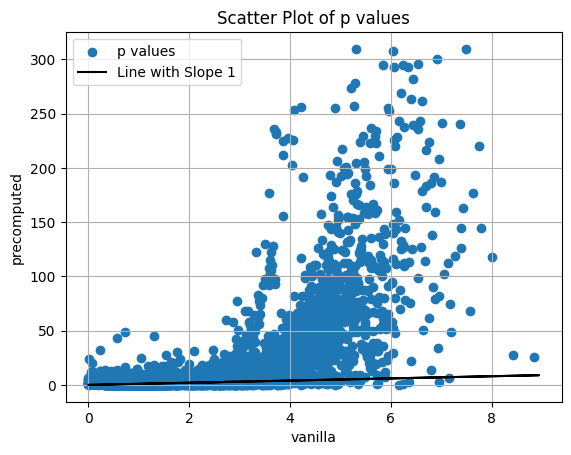

In [39]:
x = -1 * np.log10(vanilla_memento_result_df["de_pval"])
y = -1 * np.log10(filtered_precomputed_memento_result_df["pval"])

plt.scatter(x, y, label="p values")

plt.plot(x, x, color="black", label="Line with Slope 1")

plt.xlabel("vanilla")
plt.ylabel("precomputed")

plt.title("Scatter Plot of p values")
plt.legend()

plt.grid(True)
plt.show()